In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import sys, os, pickle, time, warnings, h5py
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac

from multiprocessing import Pool

In [12]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

## Mock sample

In [37]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils
from TracerFit import mwfit, int_idx

In [25]:
model = mwfit(sf_bool=False, perr_bool=False)

In [42]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample_1m.h'
with h5py.File(filename, 'r') as hf:
    subset = np.arange(len(hf['sample']['source_id'][...]))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])

In [35]:
run_id=4
size = 99900
file = "sample"

model = mwfit(sf_bool=False, perr_bool=False)
model.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_full_{run_id:03d}.h')

model._generate_fid_pars()
model.sample=sample
true_params_f = model.transform_params(model.get_true_params(true_pars))

(10.0, 400000)

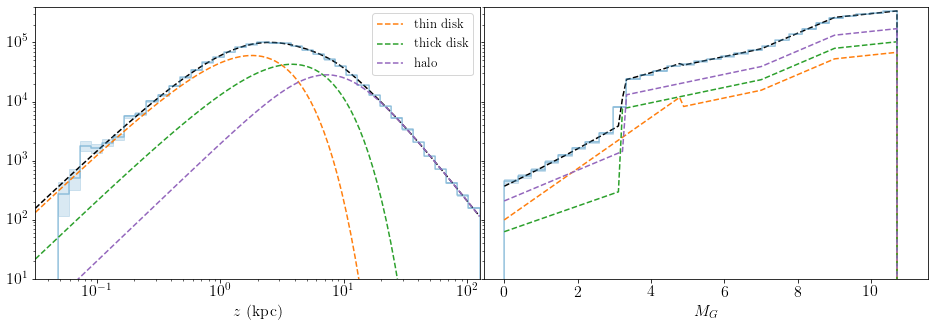

In [41]:
fig, axes = plt.subplots(1,2,figsize=(16,5), sharey=True)

parameters = true_params_f.copy()

mcmc_samples = 10
nwalker, nstep, ndim = model.mcmc_results['chain']['full_mcmc'].shape
flat_chain = model.mcmc_results['chain']['full_mcmc'][:,int(nstep/2):].reshape(-1,ndim)
mcmc_samples = flat_chain[np.random.choice(np.arange(flat_chain.shape[0]), 10, replace=False)]

true_kwargs = ({'c':'k','alpha':1, 'linestyle':'--'}, 
               {'c':'tab:orange','alpha':1, 'linestyle':'--', 'label':'thin disk'}, 
               {'c':'tab:green','alpha':1, 'linestyle':'--', 'label':'thick disk'}, 
               {'c':'tab:purple','alpha':1, 'linestyle':'--', 'label':'halo'})

mcmc_kwargs = ({'c':'k','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:orange','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:green','alpha':0.3, 'linestyle':':'}, 
               {'c':'tab:purple','alpha':0.3, 'linestyle':':'})

plt.sca(axes[0])
zlim = (-1.5,2.1)
z_arr = np.logspace(zlim[0],zlim[1],101)
import matplotlib.pyplot as plt
axes[0].plot(z_arr, dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars), **true_kwargs[0])
plotting.plot_hist(model.sample['s']*model.sample['sinb'], np.logspace(zlim[0],zlim[1],41), ax=axes[0], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})
plt.yscale('log'); plt.xlabel(r'$z$ (kpc)'); plt.xlim(0,20)

components = dh_msto.z_model(z_arr, parameters, fid_pars=model.fid_pars, model='all')
for i in range(3): axes[0].plot(z_arr, components[:,i], **true_kwargs[i+1]) 
    
plt.xscale('log')
plt.xlim(10**zlim[0],10**zlim[1])
plt.legend()

plt.sca(axes[1])
M_arr = np.sort(np.append(np.linspace(0.,11.,100), 
                          np.array([true_pars['Mx'], true_pars['Mms'], true_pars['Mms1'], 
                                    true_pars['Mms2']])))
axes[1].plot(M_arr, dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars), **true_kwargs[0])
plotting.plot_hist(sample['M'], np.linspace(0,true_pars['Mx'],30), ax=axes[1], fill_poisson=True,
                  plot_kwargs={'c':cm.RdBu(0.8), 'alpha':0.5}, fill_kwargs={'color':cm.RdBu(0.8),'alpha':0.2})


components = dh_msto.M_model(M_arr, parameters, fid_pars=model.fid_pars, model='all')
for i in range(3): axes[1].plot(M_arr, components[:,i], **true_kwargs[i+1])

plt.yscale('log'); plt.xlabel(r'$M_G$')
        
plt.subplots_adjust(wspace=0.01)

plt.ylim(10.,400000)

### Selection Function

In [ ]:
# Apply Gaia Selection Function
sample['gaiasf_subset'] = sf_utils.apply_gaiasf(sample['l'], np.arcsin(sample['sinb']), sample['m'])[0]

### Error Calculation

In [6]:
np.random.uniform(0.005, 0.008)

0.00741324217903242

In [7]:
import time
import numpy as np


def log_prob(theta):
    t = time.time() + np.random.uniform(0.00005, 0.00008)
    while True:
        if time.time() >= t:
            break
    return -0.5 * np.sum(theta ** 2)

In [8]:
import emcee

np.random.seed(42)
initial = np.random.randn(32, 5)
nwalkers, ndim = initial.shape
nsteps = 100

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
start = time.time()
sampler.run_mcmc(initial, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

100%|██████████| 100/100 [00:00<00:00, 308.00it/s]

Serial took 0.3 seconds


In [9]:
from multiprocessing import Pool

with Pool(3) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, pool=pool)
    start = time.time()
    sampler.run_mcmc(initial, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

100%|██████████| 100/100 [00:00<00:00, 286.02it/s]

Multiprocessing took 0.4 seconds
0.9 times faster than serial


In [1]:
"""
Generate sample from three component disk model:
-Exponential disk
-Exponential disk
-Power law halo
"""

import sys, os, pickle
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np, h5py, scipy, scipy.stats, emcee, tqdm
from multiprocessing import Pool
from copy import deepcopy as copy

In [2]:
def dwarf_magnitude(M, alpha1=-0.5, alpha2=-1.,
                 Mto=4., Mms=8., Mms1=9., Mms2=7., Mx=10.):

    M = M[0]
    if (M<Mto)|(M>Mx): return -1e30

    ep1=1.3; ep2=2.3;
    a1=-np.log(10)*(ep1-1)/(2.5*alpha1); a2=-np.log(10)*(ep2-1)/(2.5*alpha2);

    alphag = (np.log(a1/a2) - alpha1*(Mms-Mms1) + alpha2*(Mms-Mms2))/(Mms1-Mms2)
    Ag = 1/a1 * np.exp((alpha1-alphag)*(Mms-Mms1))

    if M>Mms1: return - np.log(a1) + alpha1*(Mms-M)
    elif M>Mms2: return np.log(Ag) + alphag*(Mms-M)
    elif M>Mto: return - np.log(a2) + alpha2*(Mms-M)
    else: raise ValueError('No good mag range')

def giant_magnitude(M, alpha3=-0.5, Mto=4.):

    M = M[0]
    if (M>Mto): return -1e30

    else: return -alpha3*M

def disk_pos(s, sinb, hz=1., R0=8.27, theta_deg=60):

    if (sinb<np.sin(np.deg2rad(theta_deg)))|(sinb>1)|(s<0): return -1e30

    return 2*np.log(s) - s*sinb/hz

def halo_pos(s, sinb, hz=1., R0=8.27, theta_deg=60):

    if (sinb<np.sin(np.deg2rad(theta_deg)))|(sinb>1)|(s<0): return -1e30

    return 2*np.log(s) - hz/2*np.log((s*sinb)**2 + R0**2)

In [3]:
burnt_samples = {}
for j in range(3):
    burnt_samples[j]={}

selected_samples = {}
for j in range(3):
    selected_samples[j]={}

nsample = 1000000
ncores=20
nwalkers=30
nstep=int(500 + nsample /nwalkers /ncores * 2 * 5)
print('Nsample: ', nsample)


alpha1=-0.15; alpha2=-0.3
Mms=8.; Mms1=9.; Mms2=7.; Mx=10.7
R0=8.27; theta_deg=60
# Parameters for all three components of the model.
global_params = {'alpha1':-0.15, 'alpha2':-0.3,
                'Mms':8., 'Mms1':9., 'Mms2':7., 'Mx':10.7,
                'R0':8.27, 'theta_deg':60, 'N':nsample}
# Individual independent component parameters.
params = {0: {'hz':0.9, 'alpha3':-1.,  'Mto':4.8, 'fD':0.94, 'w':0.2},
          1: {'hz':1.9, 'alpha3':-0.5, 'Mto':3.14, 'fD':0.998, 'w':0.3},
          2: {'hz':4.6, 'alpha3':-0.6,  'Mto':3.3, 'fD':0.995,  'w':0.5}}
print(params)

weights = np.array([params[j]['w'] for j in range(3)])
j_nsample = np.round(weights * nsample).astype(int)
j_nsample[-1] = nsample-np.sum(j_nsample[:-1])

fdwarf = np.array([params[j]['fD'] for j in range(3)])
j_ndwarf = np.round(j_nsample * fdwarf).astype(int)
j_ngiant = j_nsample - np.round(j_nsample * fdwarf).astype(int)

Nsample:  1000000
{0: {'hz': 0.9, 'alpha3': -1.0, 'Mto': 4.8, 'fD': 0.94, 'w': 0.2}, 1: {'hz': 1.9, 'alpha3': -0.5, 'Mto': 3.14, 'fD': 0.998, 'w': 0.3}, 2: {'hz': 4.6, 'alpha3': -0.6, 'Mto': 3.3, 'fD': 0.995, 'w': 0.5}}


In [4]:
ndim=1; j=0

print('Dwarf %d' % j)
def loglike(x):
    return dwarf_magnitude(x, alpha1=global_params['alpha1'], alpha2=global_params['alpha2'],
                         Mto=params[j]['Mto'], Mms=global_params['Mms'],
                         Mms1=global_params['Mms1'], Mms2=global_params['Mms2'], Mx=global_params['Mx'])

p0_walkers = np.random.rand(nwalkers,1) * (global_params['Mms1']-params[j]['Mto']) + params[j]['Mto']

Dwarf 0


In [5]:

for j in range(3):

    print('Dwarf %d' % j)
    def loglike(x):
        return dwarf_magnitude(x, alpha1=global_params['alpha1'], alpha2=global_params['alpha2'],
                             Mto=params[j]['Mto'], Mms=global_params['Mms'],
                             Mms1=global_params['Mms1'], Mms2=global_params['Mms2'], Mx=global_params['Mx'])

    

    with Pool(ncores) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, pool=pool)
        for pos,lnp,rstate in tqdm.tqdm(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
            pass

Dwarf 0


  4%|▍         | 662/17166 [00:02<01:03, 258.34it/s]Process ForkPoolWorker-36:
Process ForkPoolWorker-31:
Process ForkPoolWorker-22:
Process ForkPoolWorker-32:
Process ForkPoolWorker-40:
Process ForkPoolWorker-33:
Process ForkPoolWorker-38:
Process ForkPoolWorker-37:
Process ForkPoolWorker-24:
  4%|▍         | 671/17166 [00:02<01:05, 251.20it/s]Process ForkPoolWorker-26:
Process ForkPoolWorker-39:
Process ForkPoolWorker-23:
Traceback (most recent call last):
Process ForkPoolWorker-34:
Traceback (most recent call last):
Process ForkPoolWorker-28:
Traceback (most recent call last):
Process ForkPoolWorker-25:
Traceback (most recent call last):
Process ForkPoolWorker-27:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/mu

  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiproce

KeyboardInterrupt: 

In [6]:
iterations = np.arange(ncores)
def run_mcmc(i):
    sampler=emcee.EnsembleSampler(nwalkers, ndim, loglike)
    for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
        pass
    return sampler.chain, i

In [11]:
chain = np.zeros((ncores*nwalkers, nstep, ndim))
with Pool(ncores) as pool:
    for chain_i, i in pool.imap(run_mcmc, iterations):
        chain[i*nwalkers:(i+1)*nwalkers]=chain_i

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/si

0it [00:00, ?it/s]

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.
/home/andy/py36/lib/python3.6/si

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:






Process ForkPoolWorker-3:
Process ForkPoolWorker-14:


  params:  params:  params:

Traceback (most recent call last):


  params:


Process ForkPoolWorker-9:
Process ForkPoolWorker-20:
Process ForkPoolWorker-1:


  params:

Process ForkPoolWorker-11:


Process ForkPoolWorker-5:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


Process ForkPoolWorker-6:
Traceback (most recent call last):


   params:

Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

In [7]:
chain = run_mcmc(0)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/17166 [00:00<?, ?it/s]

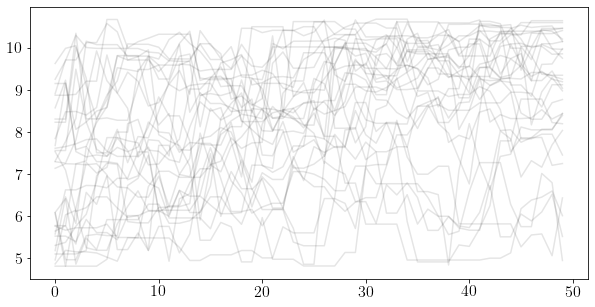

In [18]:
plt.figure(figsize=(10,5))

for ii in range(nwalkers):
    plt.plot(chain[0][ii,:50,0], alpha=0.1, c='k')

In [10]:
chain[0].shape

(30, 17166, 1)

In [42]:
p0_walkers = np.random.rand(nwalkers,1) * (global_params['Mms1']-params[j]['Mto']) + params[j]['Mto']

sampler=emcee.EnsembleSampler(nwalkers, ndim, loglike)

In [43]:
for pos,lnp,rstate in sampler.sample(p0_walkers, iterations=nstep):
    pass

ValueError: incompatible input dimensions

In [41]:
p0_walkers.shape

(30, 1)

In [18]:
pool.imap?

In [20]:
iterations

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

ValueError: incompatible input dimensions